In [1]:
import numpy as np
import tensorflow as tf
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras import models
from keras import layers
from ActivationHeatmap.net import cnn_net
import matplotlib.pyplot as plt
import util.image_import as ii
import json, os
from keras import backend as K
import cv2

Using TensorFlow backend.


In [2]:
model = cnn_net()
model.load_weights('ActivationHeatmap/cnn_weights.hdf5')

In [5]:
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x*=0.1
    x+=0.5
    x = np.clip(x, 0, 1)
    x*=255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [54]:
def generate_pattern(layer_name, filter_index, size=150):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])
    grads = K.gradients(loss, model.input)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    iterate = K.function([model.input], [loss, grads])
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    step = 1.
    for i in range(150):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
    img = input_img_data[0]
    return deprocess_image(img)

In [3]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
activation_2 (Activation)    (None, 109, 109, 64)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 186624)            0         
__________

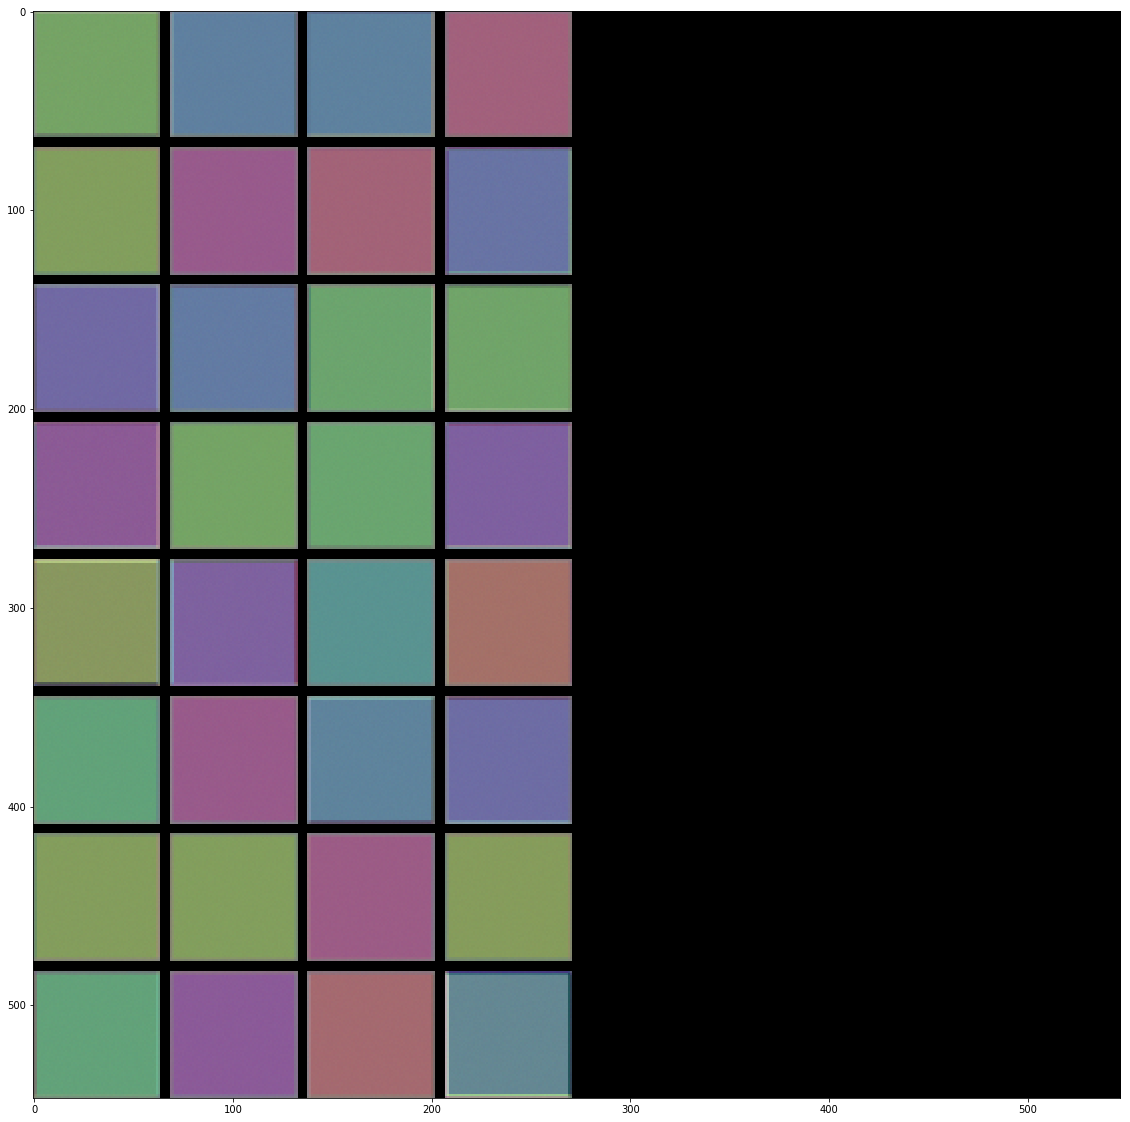

In [55]:
layer_name = 'conv2d_1'
size = 64
margin = 5
results = np.zeros((8 * size+7*margin, 8 * size+7*margin, 3))
for i in range(8):
    for j in range(4):
        filter_img = generate_pattern(layer_name, i + (j * 8), size=size)
        horizontal_start=i*size+i*margin
        horizontal_end = horizontal_start + size
        vertical_start=j*size+j*margin
        vertical_end = vertical_start + size
        results[horizontal_start: horizontal_end,vertical_start: vertical_end, :] = filter_img
plt.figure(figsize=(20, 20))
plt.imshow(results.astype(np.uint8))

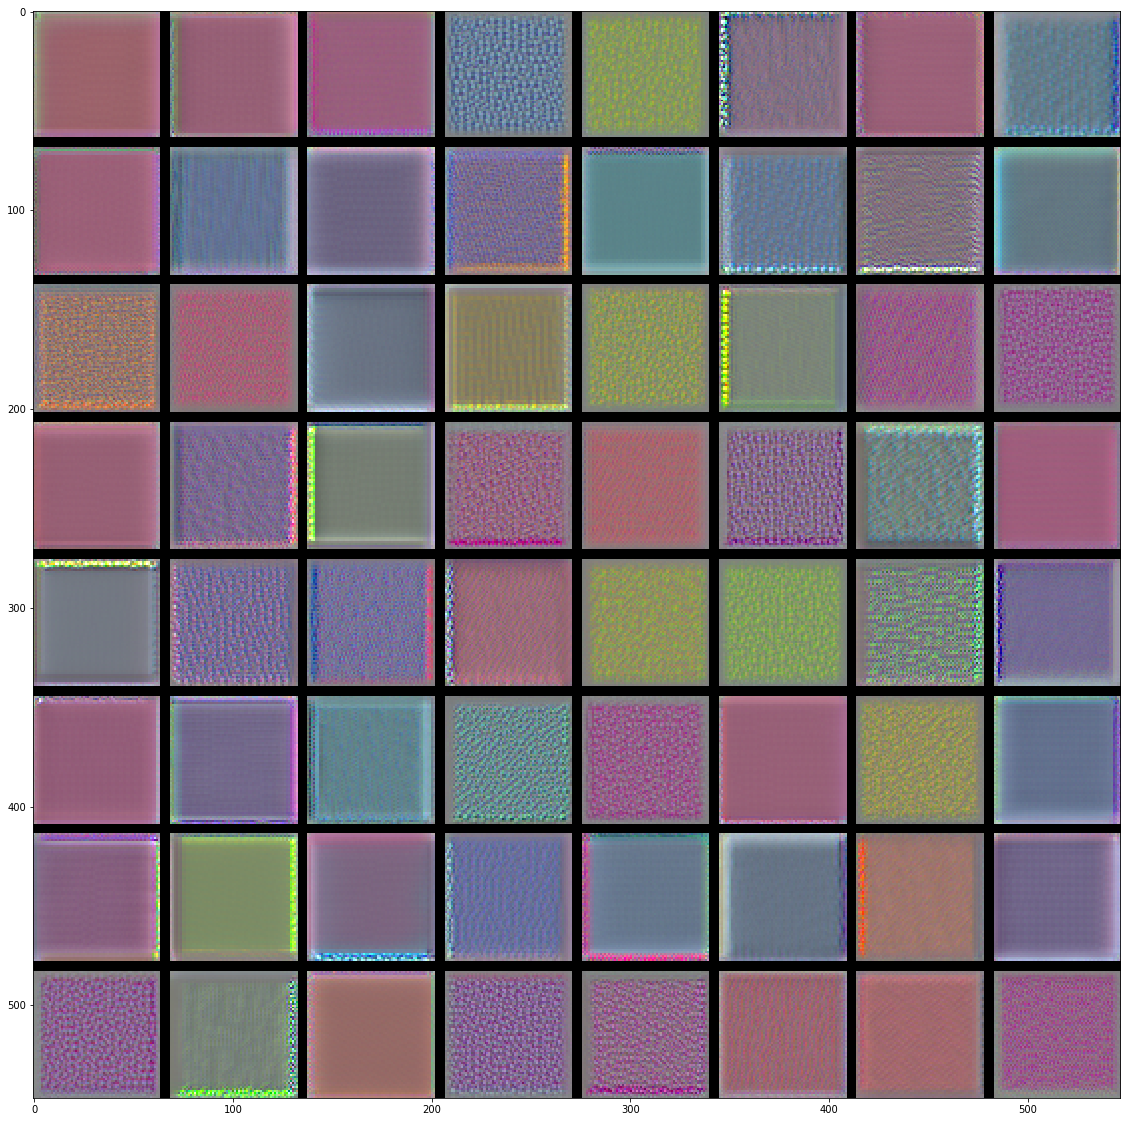

In [56]:
layer_name = 'conv2d_2'
size = 64
margin = 5
results = np.zeros((8 * size+7*margin, 8 * size+7*margin, 3))
for i in range(8):
    for j in range(8):
        filter_img = generate_pattern(layer_name, i + (j * 8), size=size)
        horizontal_start=i*size+i*margin
        horizontal_end = horizontal_start + size
        vertical_start=j*size+j*margin
        vertical_end = vertical_start + size
        results[horizontal_start: horizontal_end,vertical_start: vertical_end, :] = filter_img
plt.figure(figsize=(20, 20))
plt.imshow(results.astype(np.uint8))

# Intermediate Activations

In [57]:
def combine_labels_images():
    with open('ActivationHeatmap/label_data_copy.json') as json_file:
        data = json.load(json_file)

    orig_str = '/home/emil/Documents/github/BSc-PRO/dataset3/res_still'
    combined = []
    maps = os.listdir(orig_str)
    for m in maps:
        map_str =orig_str+'/'+m
        classes = os.listdir(map_str)
        for k in range(len(classes)):
            path_str = map_str+'/'+classes[k]
            names = os.listdir(path_str)
            count = 0
            for i in range(len(names)):
                for j in range(len(data)):
                    if names[i] == data[j]['External ID'] and (classes[k] != 'background'):
                        combined.append((m ,path_str+'/'+names[i], data[j] ))
    return combined

labels = ['bun','carrots','ketchup','background','catfood_beef','arm','catfood_salmon','potato']
train_path = '../dataset3/res_still/train'
ignore = []
mean_image_train = ii.calulate_mean(train_path, ignore) # Calculates mean for each channel for every pixel
def subtract_mean(img):
    return img - mean_image_train

combined = combine_labels_images()

Predicted: ketchup


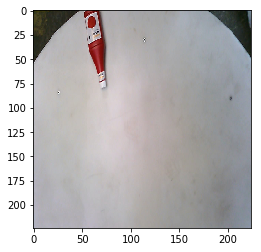

In [129]:
indx = 240
img_path = combined[indx][1]
# load image and resize to 224x224
img = image.load_img(img_path, target_size=(224,224))
plt.imshow(img)
x = image.img_to_array(img) # subtract mean
x = np.expand_dims(x, axis=0)

# Apply preprocessing
x = subtract_mean(x)*1./255
pred = np.argmax(model.predict(x))
print('Predicted: '+str(labels[pred]))

In [59]:
layer_outputs = [layer.output for layer in model.layers[:6]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [130]:
activations = activation_model.predict(x)

In [131]:
first_layer_activation = activations[3]
print(first_layer_activation.shape)

(1, 109, 109, 64)


In [132]:
#1

<Figure size 432x288 with 0 Axes>

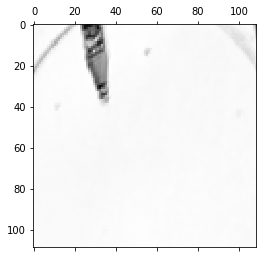

<Figure size 432x288 with 0 Axes>

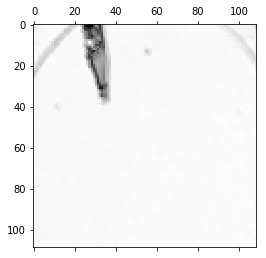

<Figure size 432x288 with 0 Axes>

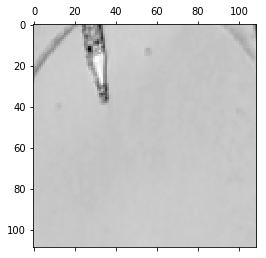

<Figure size 432x288 with 0 Axes>

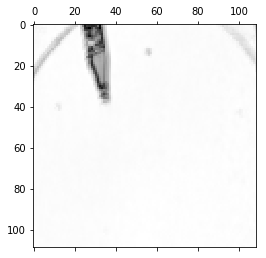

<Figure size 432x288 with 0 Axes>

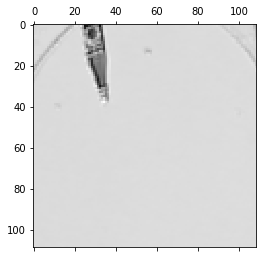

<Figure size 432x288 with 0 Axes>

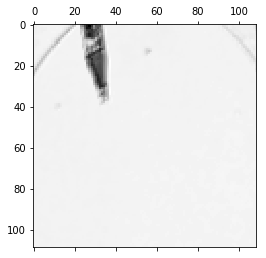

<Figure size 432x288 with 0 Axes>

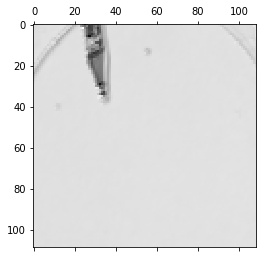

<Figure size 432x288 with 0 Axes>

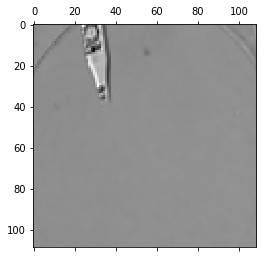

<Figure size 432x288 with 0 Axes>

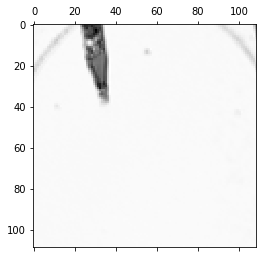

<Figure size 432x288 with 0 Axes>

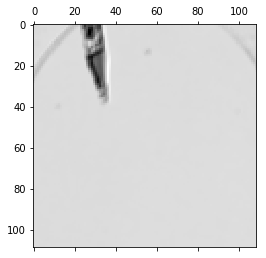

<Figure size 432x288 with 0 Axes>

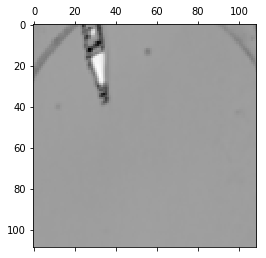

<Figure size 432x288 with 0 Axes>

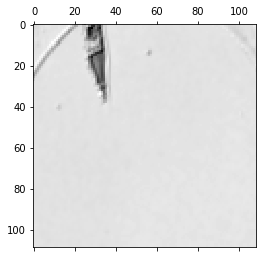

<Figure size 432x288 with 0 Axes>

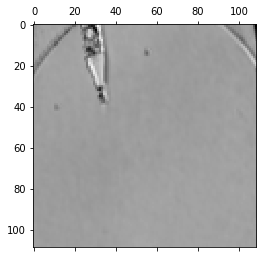

<Figure size 432x288 with 0 Axes>

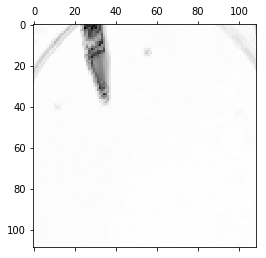

<Figure size 432x288 with 0 Axes>

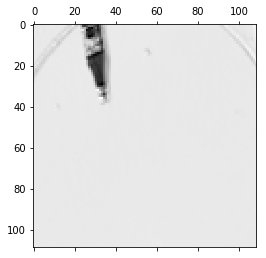

<Figure size 432x288 with 0 Axes>

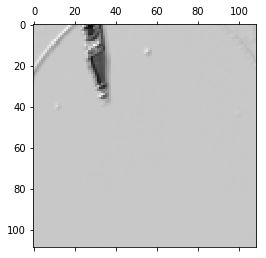

<Figure size 432x288 with 0 Axes>

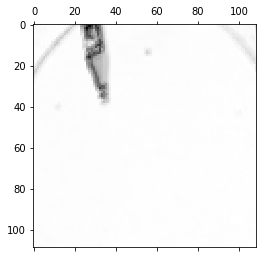

<Figure size 432x288 with 0 Axes>

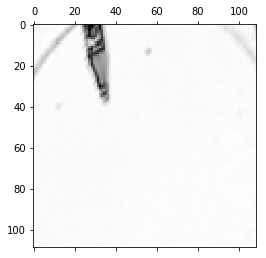

<Figure size 432x288 with 0 Axes>

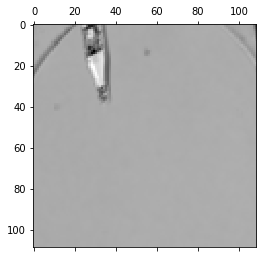

<Figure size 432x288 with 0 Axes>

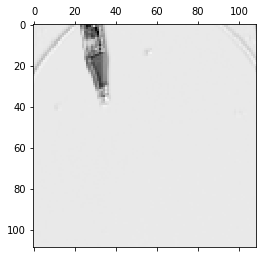

<Figure size 432x288 with 0 Axes>

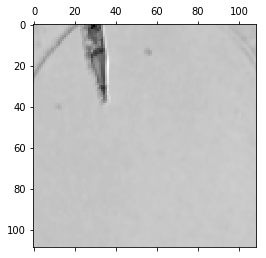

<Figure size 432x288 with 0 Axes>

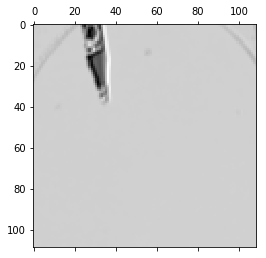

<Figure size 432x288 with 0 Axes>

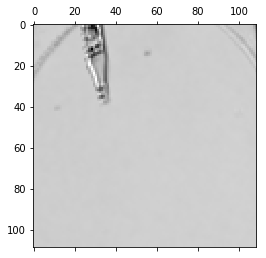

<Figure size 432x288 with 0 Axes>

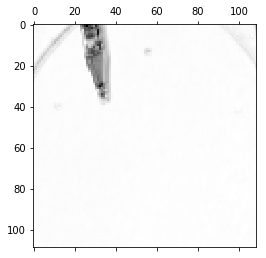

<Figure size 432x288 with 0 Axes>

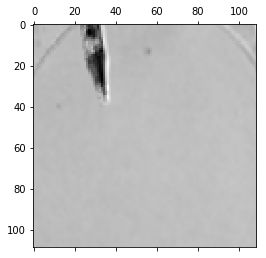

<Figure size 432x288 with 0 Axes>

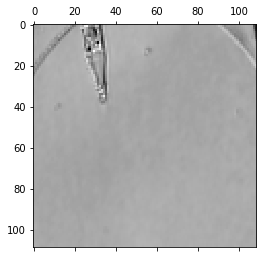

<Figure size 432x288 with 0 Axes>

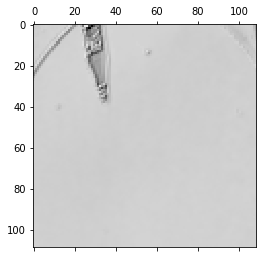

<Figure size 432x288 with 0 Axes>

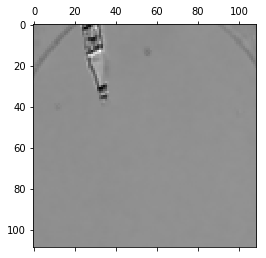

<Figure size 432x288 with 0 Axes>

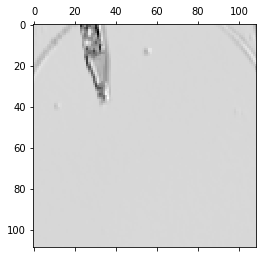

<Figure size 432x288 with 0 Axes>

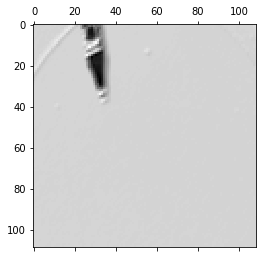

<Figure size 432x288 with 0 Axes>

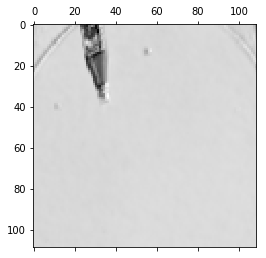

<Figure size 432x288 with 0 Axes>

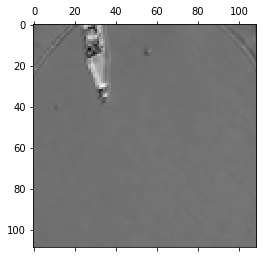

<Figure size 432x288 with 0 Axes>

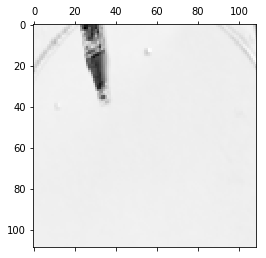

<Figure size 432x288 with 0 Axes>

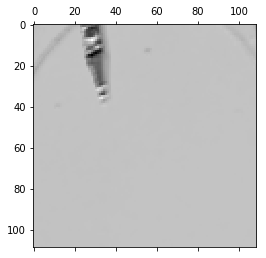

<Figure size 432x288 with 0 Axes>

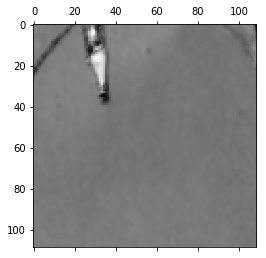

<Figure size 432x288 with 0 Axes>

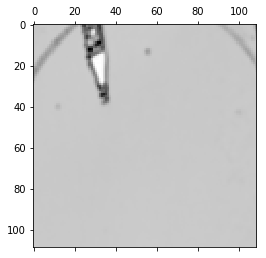

<Figure size 432x288 with 0 Axes>

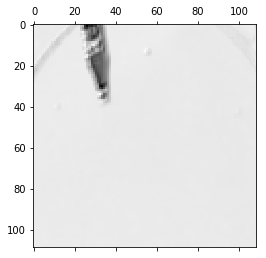

<Figure size 432x288 with 0 Axes>

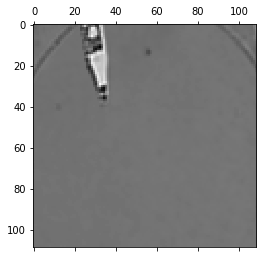

<Figure size 432x288 with 0 Axes>

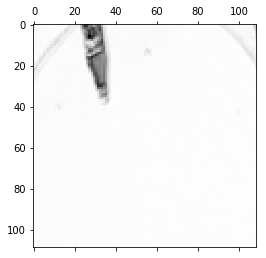

<Figure size 432x288 with 0 Axes>

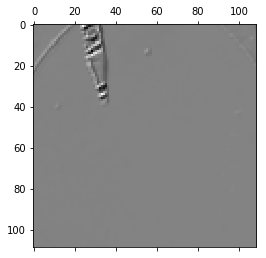

<Figure size 432x288 with 0 Axes>

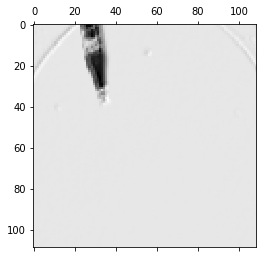

<Figure size 432x288 with 0 Axes>

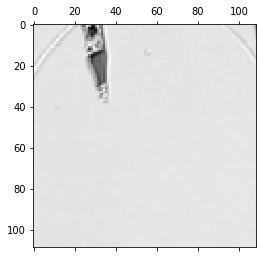

<Figure size 432x288 with 0 Axes>

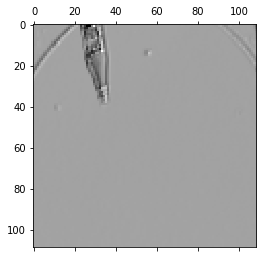

<Figure size 432x288 with 0 Axes>

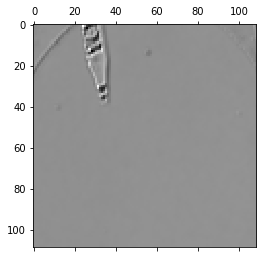

<Figure size 432x288 with 0 Axes>

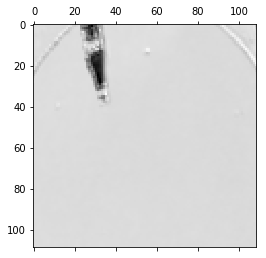

<Figure size 432x288 with 0 Axes>

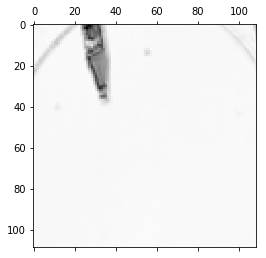

<Figure size 432x288 with 0 Axes>

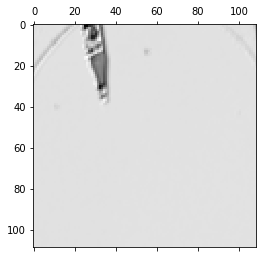

<Figure size 432x288 with 0 Axes>

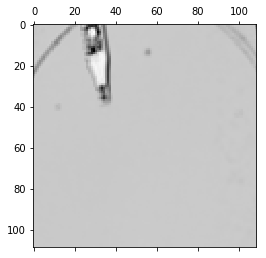

<Figure size 432x288 with 0 Axes>

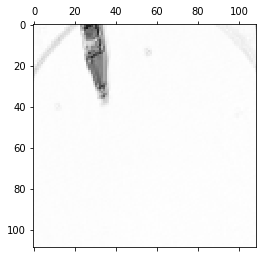

<Figure size 432x288 with 0 Axes>

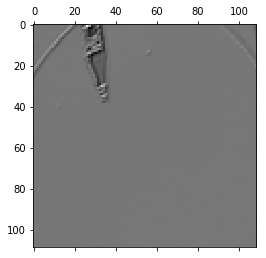

<Figure size 432x288 with 0 Axes>

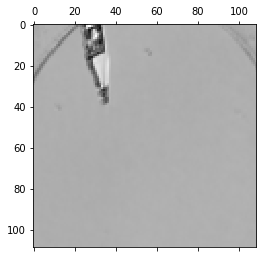

<Figure size 432x288 with 0 Axes>

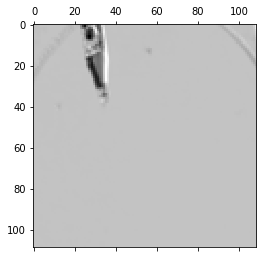

<Figure size 432x288 with 0 Axes>

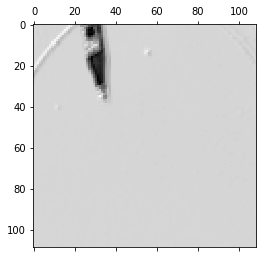

<Figure size 432x288 with 0 Axes>

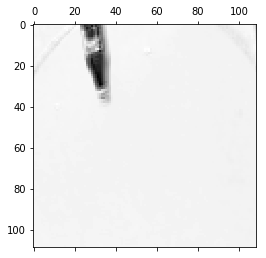

<Figure size 432x288 with 0 Axes>

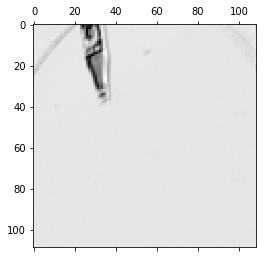

<Figure size 432x288 with 0 Axes>

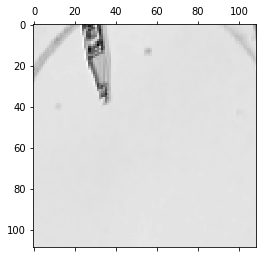

<Figure size 432x288 with 0 Axes>

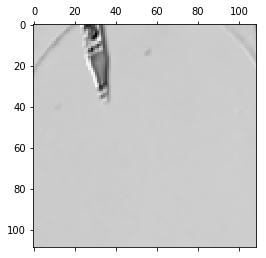

<Figure size 432x288 with 0 Axes>

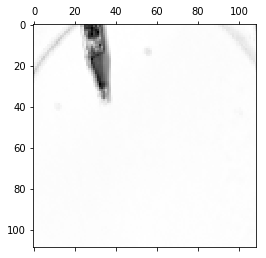

<Figure size 432x288 with 0 Axes>

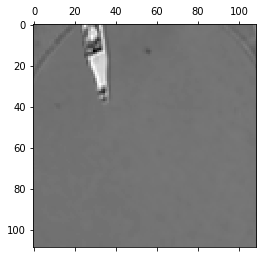

<Figure size 432x288 with 0 Axes>

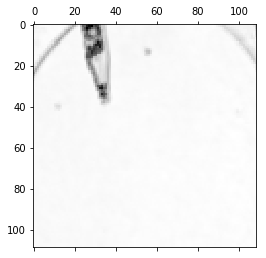

<Figure size 432x288 with 0 Axes>

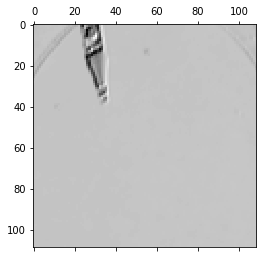

<Figure size 432x288 with 0 Axes>

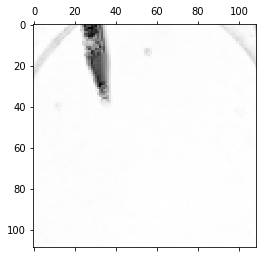

<Figure size 432x288 with 0 Axes>

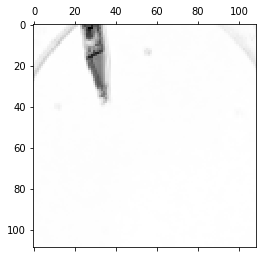

<Figure size 432x288 with 0 Axes>

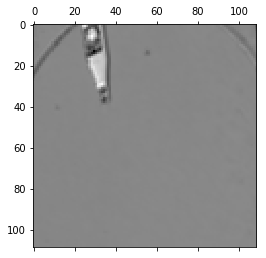

In [133]:
for i in range(64):
    plt.figure()
    plt.matshow(first_layer_activation[0, :, :, i], cmap='gray')